# IMDB data

In [1]:
import keras
import time
from nltk.corpus import stopwords
import nltk
import os
%matplotlib inline

Using TensorFlow backend.


# Loading IMDB dataset
Just like the previous section, we load the IMDB dataset from keras, remove STOP words, and build the train and test sets

In [2]:
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatajadd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
NUM_WORDS=10000 # only use top <NUM_WORDS> words
INDEX_FROM=3   # word index offset

train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS,
                                           index_from=INDEX_FROM,
                                           skip_top=0,
                                           maxlen=None,
                                           start_char=1,
                                           oov_char=2
                                          )
train_x,train_y = train
test_x,test_y = test

# build id_to_word and word_to_id while removing stop words
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items() if k not in STOP_WORDS}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
#word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}
# remove stop words from train and test
train_x = [[wordid for wordid in review if wordid in id_to_word] for review in train_x]
test_x = [[wordid for wordid in review if wordid in id_to_word] for review in test_x]
#print(' '.join(id_to_word[id] for id in train_x[3] ))

# Training FastText with Gensim
In this section, we want to train a FastText model from scratch. 
First, we need a Streamer to stream lines of text in the corpus on at a time. We can pass the text file path, if the data is stored on disk. For the purpose of this tutoria, because train set is already loaded to memory, we can pass it to the Streamer as-is.
For details about Gensim, please refer to the documnetation. https://radimrehurek.com/gensim/auto_examples/index.html

In [4]:
# We need an streamer ...
from gensim.models.fasttext import FastText as FT_gensim
class Streamer(object):
    def __init__(self, file):
        self.file = file
    def __iter__(self):
        for line in self.file:
            yield [id_to_word[item] for item in line]

Let's check and see how the Streamer works:

In [5]:
n = 0
for i in Streamer(train_x):
    if n< 2:
        print("review length in words: {}".format(len(i)))
        n +=1 
    else:
        break
    

review length in words: 96
review length in words: 100


Now we need to construct the FastText Model with the following hyper paramters:

- embedding_size : The dimension or size of each embedding vector
- window: The size of the moving window to use
- sg: Skip-gram,1, or CBOW structure,0, 
- negative: number of negative samples used
- min_n and max_n: range of character n-grams to be extracted from each word
- word_ngrams: Whether to use character n-grams or not. 0 is equivalent to Word2Vec

In [6]:
embedding_size = 100
model_FT = FT_gensim(size=embedding_size,
                     window=5,
                     sg = 1,
                     negative =5,
                    min_count=0,
                    sorted_vocab = 1,
                     min_n = 2,
                     max_n = 7,
                    word_ngrams = 1,
                    workers  = 8,
                 )
model_FT.build_vocab(sentences=Streamer(train_x))
total_examples = model_FT.corpus_count
total_words = model_FT.corpus_total_words
print("{} total words in the doc, {} used words from {} total sentences".format(
        total_words,
        len(model_FT.wv.vocab),
        total_examples))

3184795 total words in the doc, 9842 used words from 25000 total sentences


Training the FastText model is as straightforward as calling the train function and providing the number of epochs to complete:

In [7]:
# run the training or load the trained model from disk.
Load_from_disk = False
rootpath = "trained_models/"
model_file_name = "model_FT_from_scratch.model"
os.makedirs(rootpath, exist_ok = True)
if not Load_from_disk:
    st = time.time()
    model_FT.train(sentences=Streamer(train_x), total_examples=total_examples, epochs=5)
    ed = time.time()
    print("train took {} minutes".format((ed-st)/60))
    model_FT.save(rootpath + model_file_name)
else:
    model_FT = FT_gensim.load(rootpath + model_file_name)

train took 4.22321648200353 minutes


C:\Users\fatajadd\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [14]:
# how to get word vector:
model_FT.wv["marriage"]

array([ 0.14946589,  0.03678733, -0.28852972, -0.21384084,  0.11283071,
        0.21730869,  0.24558349, -0.33395597, -0.16791457,  0.18458037,
        0.16809516,  0.2587512 , -0.20317397, -0.31845677,  0.03155321,
        0.09515445,  0.0070675 ,  0.02318381, -0.5805327 , -0.26274806,
       -0.714307  , -0.17041963,  0.18816146, -0.12444602,  0.10036528,
       -0.12273735,  0.01062959,  0.0908412 , -0.05251418,  0.18858571,
        0.26640624, -0.10261974,  0.17244051,  0.06753627, -0.13352247,
       -0.01754782, -0.32967034,  0.01562135,  0.42160434,  0.21873543,
        0.05428425,  0.48161045, -0.1852225 ,  0.04155449, -0.25489137,
       -0.315293  ,  0.46078458, -0.03779642, -0.2679867 ,  0.17854248,
        0.17659679, -0.3019858 ,  0.30739048,  0.0198584 , -0.4406883 ,
       -0.10759705, -0.17783082, -0.30285847, -0.20042267, -0.00184117,
        0.04123073, -0.2108062 ,  0.4039801 , -0.55871505,  0.56837785,
        0.0836841 , -0.22098637,  0.1991263 , -0.03302772, -0.06

In [9]:
# compare two words:
word1 = "good"
word2 = "nice"
for word in [word1,word2]:
    if word in model_FT.wv.vocab:
        print("{} \t\t exists".format(word))
    else:
        print("{} \t\t does NOT exist".format(word))
sim = model_FT.wv.similarity(word1, word2)
print("{} and {} are {:.3}% similar".format(word1, word2, sim*100))

good 		 exists
vnice 		 does NOT exist
good and vnice are 59.1% similar


In [21]:
# get top N words most similar to a quesry word
quyery_word = "car"
similar_words_count = 10
similar_words = model_FT.wv.similar_by_word(quyery_word,similar_words_count)
similar_words

[('truck', 0.7215304970741272),
 ('cars', 0.6850515604019165),
 ('crashes', 0.6701468229293823),
 ('warehouse', 0.669235348701477),
 ('driver', 0.6621472835540771),
 ('chases', 0.6545020341873169),
 ('chase', 0.6424366235733032),
 ('helicopter', 0.6268199682235718),
 ('shotgun', 0.6252334117889404),
 ('shootout', 0.6213974952697754)]

# Visualize Trained models
In this section, to visualize the trained FastText model, we randomly select a subset of the whole vocabulary, apply T-SNE to map each embedding vector to 2D, and plot it. We only keep labels for 1 out of every 20 words to keep the plot readable 

C:\Users\fatajadd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


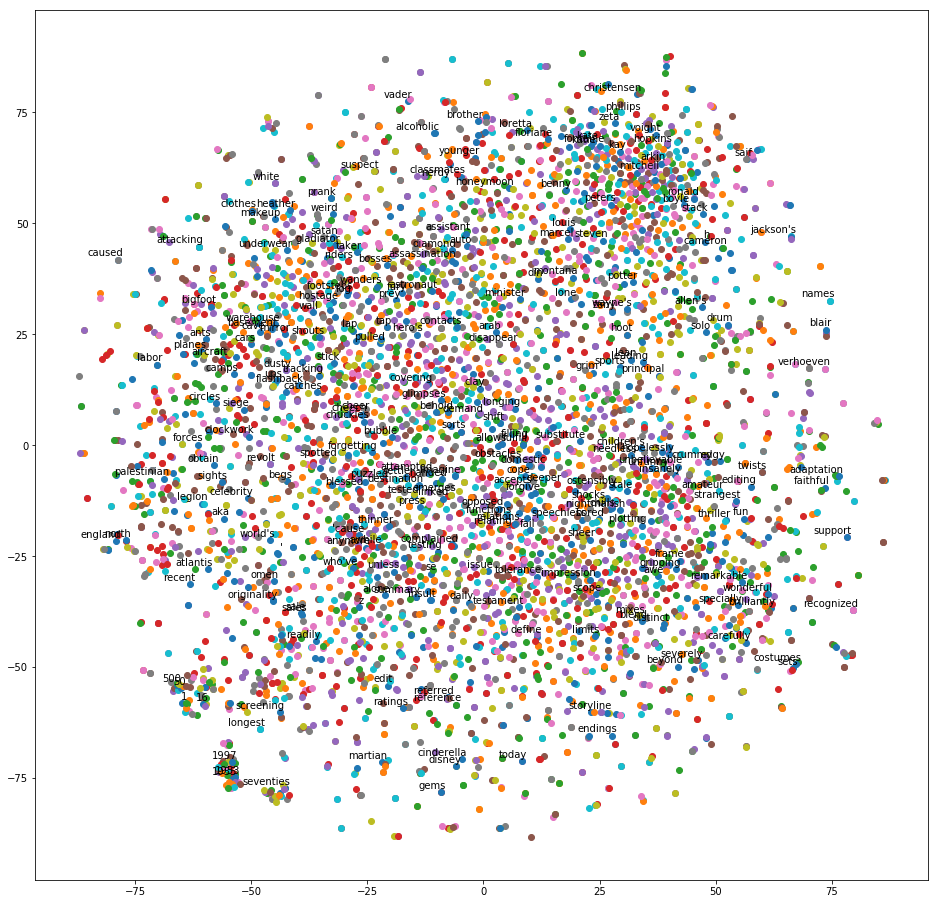

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from random import sample
def tsne_plot(model):
    """Creates and TSNE model and plots it"""
    labels = []
    tokens = []
    
    vocab =[x for x in model_FT.wv.vocab]
    index_to_plot = sample(range(0,len(vocab)),5000)
    for wordid in index_to_plot:
        tokens.append(model[vocab[wordid]])
        labels.append(vocab[wordid])
        
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        if i%20==0:
            plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model_FT)

# Use Word Embeddings for Classification
We now want to use the obtained word embeddings to train a traditional classifier. First, we need to combine the embeddings per word to come up with an embedding for each sentence. One conventional option, is to sum all the embeddigns in one sentence to build a sentence embedding vector:

In [12]:
# Build input matrices
import numpy as np
def build_inputs_with_embedding(x,
                                embedding_model = model_FT, 
                                id_to_word=id_to_word,
                                max_review_len = 200):
    """
    takes the original reviews, and builds a 2D matrix of samples*features ready to be used for ML
    Aggreagate all words in a review to get only one vector per sentence that is used later as feature
        
    """
    embedding_size = len(model_FT.wv["sample"])
    x_with_embedding = np.zeros((len(x), embedding_size))
    for i in range(len(x)):
        x_with_embedding[i,:] = np.sum([embedding_model.wv[id_to_word[j]] for j in x[i] if j<max_review_len], axis=0)
    return x_with_embedding
train_x_with_embedding = build_inputs_with_embedding(train_x)
print("train set size to use :", train_x_with_embedding.shape)
test_x_with_embedding = build_inputs_with_embedding(test_x)
print("test set size to use :", test_x_with_embedding.shape)

train set size to use : (25000, 100)
test set size to use : (25000, 100)


In [13]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=0)
RF.fit(train_x_with_embedding, train_y) 
accuracy_train = RF.score(train_x_with_embedding,train_y)
print("accuracy on train set = {:.3f}%".format(accuracy_train*100))
accuracy_test = RF.score(test_x_with_embedding,test_y)
print("accuracy on test set = {:.3f}%".format(accuracy_test*100))

accuracy on train set = 76.612%
accuracy on test set = 67.988%
